In [ ]:
# === 0) Setup ===
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score, accuracy_score,
    mean_squared_error, r2_score
)
from sklearn.linear_model import LogisticRegression, LinearRegression

from scipy import stats

RANDOM_STATE = 42
sns.set_theme()

DATA_PATH = Path("streamworks_user_data.csv")  # <-- change if needed


In [ ]:
# === 1) Load data ===
if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Could not find {DATA_PATH.resolve()}\n"
        "Place 'streamworks_user_data.csv' next to this notebook (or update DATA_PATH)."
    )

df = pd.read_csv(DATA_PATH)
df.head()


,user_id,age,gender,signup_date,last_active_date,country,subscription_type,average_watch_hours,mobile_app_usage_pct,complaints_raised,received_promotions,referred_by_friend,is_churned,monthly_fee
0,1001.0,56.0,Other,02-04-25,13-07-25,France,Standard,42.6,77.4,1.0,No,No,1.0,10.99
1,1002.0,69.0,Male,02-01-23,13-07-25,India,Basic,65.3,98.0,4.0,No,Yes,1.0,5.99
2,1003.0,46.0,Male,21-08-22,13-07-25,UK,Premium,40.1,47.8,0.0,No,Yes,1.0,13.99
3,1004.0,32.0,Other,14-09-23,13-07-25,Germany,Premium,5.8,53.2,1.0,Yes,Yes,1.0,13.99
4,1005.0,60.0,Female,29-07-23,13-07-25,India,Standard,32.7,16.8,5.0,No,Yes,0.0,9.99


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               1498 non-null   float64
 1   age                   1497 non-null   float64
 2   gender                1499 non-null   object 
 3   signup_date           1498 non-null   object 
 4   last_active_date      1498 non-null   object 
 5   country               1497 non-null   object 
 6   subscription_type     1497 non-null   object 
 7   average_watch_hours   1496 non-null   float64
 8   mobile_app_usage_pct  1498 non-null   float64
 9   complaints_raised     1497 non-null   float64
 10  received_promotions   1497 non-null   object 
 11  referred_by_friend    1497 non-null   object 
 12  is_churned            1499 non-null   float64
 13  monthly_fee           1355 non-null   float64
dtypes: float64(7), object(7)
memory usage: 164.2+ KB


In [ ]:
df.describe(include="all").T
# Missing values
df.isnull().sum().sort_values(ascending=False)
# Quick categorical counts (top categories)
cat_cols = df.select_dtypes(include=["object"]).columns
for c in cat_cols:
    print("\n", c)
    display(df[c].value_counts(dropna=False).head(10))




 gender


,count
gender,
Female,510
Other,506
Male,483
NaN,1



 signup_date


,count
signup_date,
19-09-23,6
26-01-23,6
30-05-24,6
28-10-24,6
29-08-23,6
20-06-25,5
28-08-23,5
24-02-24,5
19-06-24,5



 last_active_date


,count
last_active_date,
13-07-25,1498
NaN,2



 country


,count
country,
Canada,262
India,259
France,254
Germany,246
UK,241
USA,235
NaN,3



 subscription_type


,count
subscription_type,
Basic,505
Premium,499
Standard,493
NaN,3



 received_promotions


,count
received_promotions,
No,763
Yes,734
NaN,3



 referred_by_friend


,count
referred_by_friend,
Yes,752
No,745
NaN,3


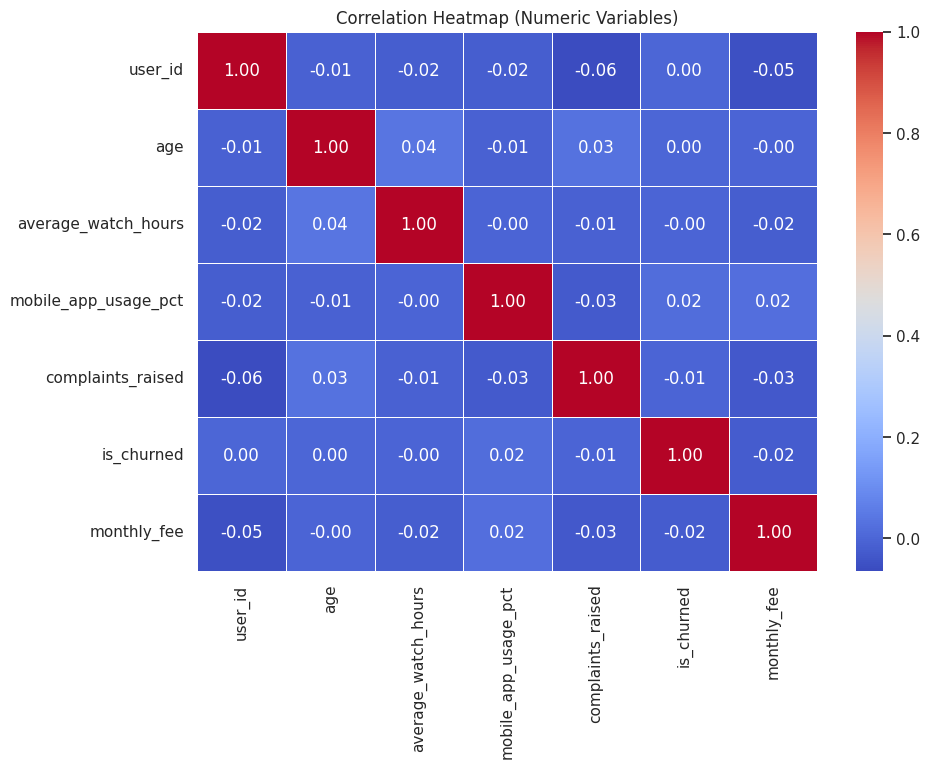

In [ ]:
# Correlation matrix & heatmap (numeric only)
num_df = df.select_dtypes(include=[np.number]).copy()
corr = num_df.corr(numeric_only=True)

plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap (Numeric Variables)")
plt.show()


In [ ]:
# Convert date columns to datetime
date_cols = ["signup_date", "last_active_date"]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")

# Tenure features
df["tenure_days"] = (df["last_active_date"] - df["signup_date"]).dt.days
df["is_loyal"] = (df["tenure_days"] > 180).astype(int)

# Sanity checks
df[date_cols + ["tenure_days", "is_loyal"]].head()


/tmp/ipython-input-2845869640.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors="coerce")


,signup_date,last_active_date,tenure_days,is_loyal
0,2025-02-04,2025-07-13,159.0,0
1,2023-02-01,2025-07-13,893.0,1
2,2022-08-21,2025-07-13,1057.0,1
3,2023-09-14,2025-07-13,668.0,1
4,2023-07-29,2025-07-13,715.0,1


In [ ]:
# Missing values handling
# Strategy:
# - For numeric columns: impute median
# - For categorical columns: impute mode ("Unknown" fallback)
# - For tenure_days: if missing due to dates, impute median after feature creation

df_work = df.copy()

numeric_cols = df_work.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_work.select_dtypes(include=["object"]).columns.tolist()

# Remove target and identifiers from imputation lists where appropriate
TARGET = "is_churned"
ID_COL = "user_id"

if ID_COL in numeric_cols: numeric_cols.remove(ID_COL)
if TARGET in numeric_cols: numeric_cols.remove(TARGET)

for c in numeric_cols:
    df_work[c] = df_work[c].fillna(df_work[c].median())

for c in categorical_cols:
    mode = df_work[c].mode(dropna=True)
    fill_val = mode.iloc[0] if len(mode) else "Unknown"
    df_work[c] = df_work[c].fillna(fill_val)

df_work.isnull().sum().sort_values(ascending=False).head(10)


,0
user_id,2
signup_date,2
last_active_date,2
is_churned,1
gender,0
country,0
subscription_type,0
age,0
average_watch_hours,0
mobile_app_usage_pct,0


In [ ]:
df_fe = df_work.copy()

# Avoid division by zero
df_fe["watch_per_fee_ratio"] = df_fe["average_watch_hours"] / df_fe["monthly_fee"].replace({0: np.nan})
df_fe["watch_per_fee_ratio"] = df_fe["watch_per_fee_ratio"].fillna(df_fe["watch_per_fee_ratio"].median())

df_fe["heavy_mobile_user"] = (df_fe["mobile_app_usage_pct"] > 70).astype(int)

# Low watch time threshold (25th percentile)
low_watch_threshold = df_fe["average_watch_hours"].quantile(0.25)
df_fe["low_watch_time"] = (df_fe["average_watch_hours"] <= low_watch_threshold).astype(int)

# Interaction: received promotions AND low watch time
# Normalize values to Yes/No for safety
df_fe["received_promotions"] = df_fe["received_promotions"].astype(str).str.strip()
df_fe["promo_and_low_watch"] = ((df_fe["received_promotions"].str.lower() == "yes") & (df_fe["low_watch_time"] == 1)).astype(int)

df_fe[["watch_per_fee_ratio", "heavy_mobile_user", "low_watch_time", "promo_and_low_watch"]].head()


,watch_per_fee_ratio,heavy_mobile_user,low_watch_time,promo_and_low_watch
0,3.876251,1,0,0
1,10.901503,1,0,0
2,2.866333,0,0,0
3,0.414582,0,1,1
4,3.273273,0,0,0


In [ ]:
def chi_square_test(feature: str):
    ct = pd.crosstab(df_fe[feature], df_fe[TARGET])
    chi2, p, dof, expected = stats.chi2_contingency(ct)
    return ct, chi2, p, dof

for feat in ["gender", "received_promotions", "referred_by_friend"]:
    ct, chi2, p, dof = chi_square_test(feat)
    display(ct)
    print(f"{feat}: chi2={chi2:.3f}, dof={dof}, p-value={p:.6f}")


is_churned,0.0,1.0
gender,,
Female,375,136
Male,378,105
Other,395,110


gender: chi2=4.424, dof=2, p-value=0.109469


is_churned,0.0,1.0
received_promotions,,
No,573,193
Yes,575,158


received_promotions: chi2=2.569, dof=1, p-value=0.108971


is_churned,0.0,1.0
referred_by_friend,,
No,563,182
Yes,585,169


referred_by_friend: chi2=0.740, dof=1, p-value=0.389535


In [ ]:
# Two-sample t-test: average_watch_hours between churned and retained
watch_churn = df_fe.loc[df_fe[TARGET] == 1, "average_watch_hours"].dropna()
watch_keep = df_fe.loc[df_fe[TARGET] == 0, "average_watch_hours"].dropna()

t_stat, p_val = stats.ttest_ind(watch_churn, watch_keep, equal_var=False)  # Welch's t-test
print(f"Welch's t-test: t={t_stat:.3f}, p-value={p_val:.6f}")
print("Mean watch hours - churned:", watch_churn.mean())
print("Mean watch hours - retained:", watch_keep.mean())


Welch's t-test: t=-0.179, p-value=0.857656
Mean watch hours - churned: 39.7037037037037
Mean watch hours - retained: 39.95688153310105


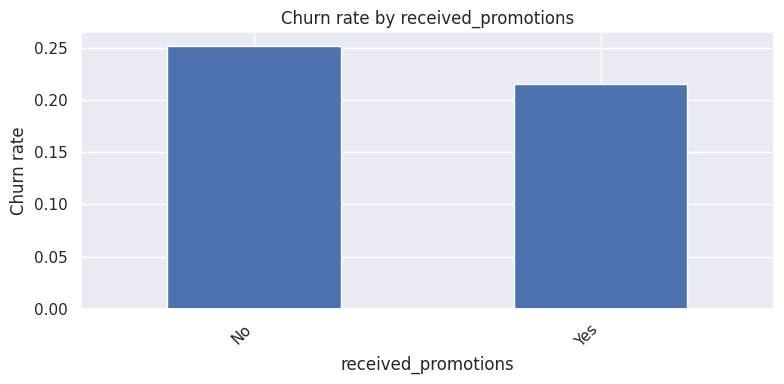

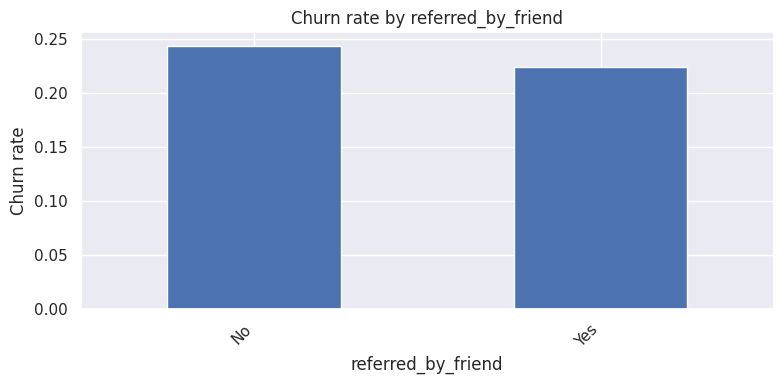

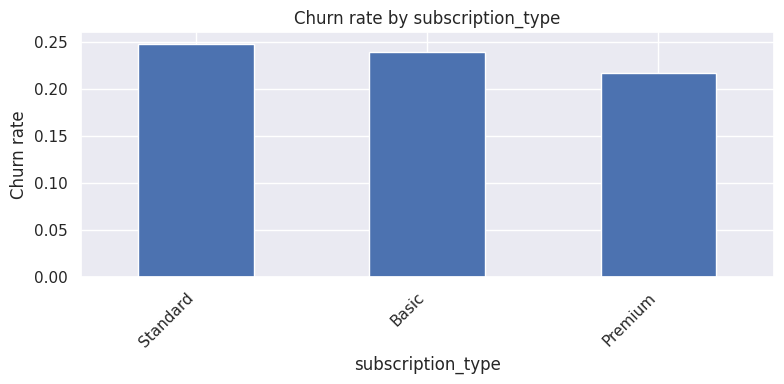

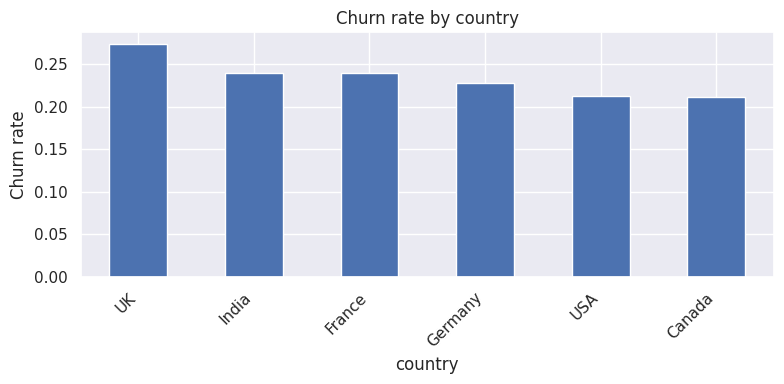

In [ ]:
# Churn rate by promotions / referral / subscription type
def churn_rate_bar(col, figsize=(8,4)):
    rate = df_fe.groupby(col)[TARGET].mean().sort_values(ascending=False)
    plt.figure(figsize=figsize)
    rate.plot(kind="bar")
    plt.ylabel("Churn rate")
    plt.title(f"Churn rate by {col}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

for col in ["received_promotions", "referred_by_friend", "subscription_type", "country"]:
    churn_rate_bar(col)


In [ ]:
# Prepare features and target
import numpy as np
import pandas as pd

# --- Robust target cleaning ---
y_raw = df_fe[TARGET].copy()

# If it's boolean, keep it
if pd.api.types.is_bool_dtype(y_raw):
    y = y_raw.astype(int)

# If it's numeric already, coerce and drop bad rows
elif pd.api.types.is_numeric_dtype(y_raw):
    y_num = pd.to_numeric(y_raw, errors="coerce")
    # replace inf/-inf with NaN then handle
    y_num = y_num.replace([np.inf, -np.inf], np.nan)
    # keep only rows with valid target
    valid = y_num.notna()
    df_fe = df_fe.loc[valid].copy()
    y = y_num.loc[valid].astype(int)

# Otherwise it's probably strings like "Yes/No", "Churned/Active", etc.
else:
    y_str = y_raw.astype(str).str.strip().str.lower()
    mapping = {
        "1": 1, "true": 1, "yes": 1, "y": 1, "churn": 1, "churned": 1,
        "0": 0, "false": 0, "no": 0, "n": 0, "active": 0, "not churned": 0
    }
    y_mapped = y_str.map(mapping)
    valid = y_mapped.notna()
    df_fe = df_fe.loc[valid].copy()
    y = y_mapped.loc[valid].astype(int)

print("Target distribution:\n", y.value_counts(dropna=False))

# Drop identifiers and leakage-prone columns (dates)
drop_cols = [TARGET, ID_COL, "signup_date", "last_active_date"]
X = df_fe.drop(columns=[c for c in drop_cols if c in df_fe.columns])

# Identify columns by type
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

# Preprocess: scale numeric, one-hot encode categoricals
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

logit = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE)

clf = Pipeline(steps=[("preprocess", preprocess), ("model", logit)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1:", f1_score(y_test, y_pred, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))


Target distribution:
 is_churned
0    1148
1     351
Name: count, dtype: int64
Accuracy: 0.4866666666666667
Precision: 0.2
Recall: 0.4
F1: 0.26666666666666666
ROC-AUC: 0.46459627329192543

Classification report:
               precision    recall  f1-score   support

           0       0.74      0.51      0.61       230
           1       0.20      0.40      0.27        70

    accuracy                           0.49       300
   macro avg       0.47      0.46      0.44       300
weighted avg       0.61      0.49      0.53       300



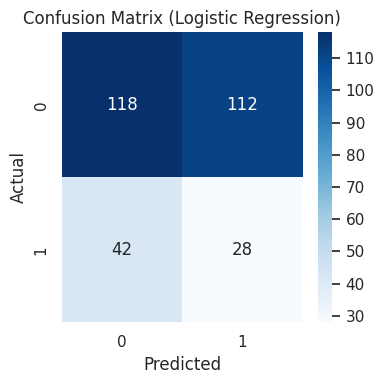

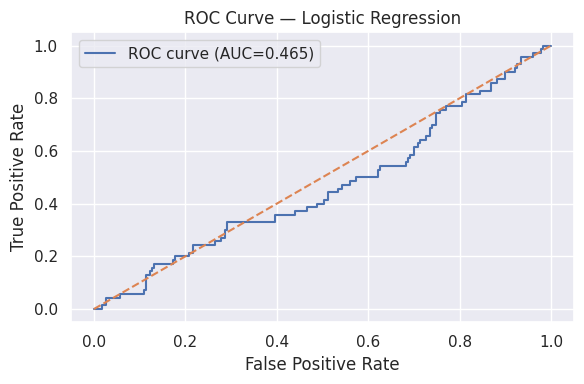

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Logistic Regression)")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Interpret coefficients: map back to feature names
# Get transformed feature names
ohe = clf.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

feature_names = np.concatenate([numeric_features, cat_feature_names])

coefs = clf.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()

display(coef_df.sort_values("abs_coef", ascending=False).head(15))


,feature,coef,abs_coef
7,watch_per_fee_ratio,-0.240171,0.240171
10,promo_and_low_watch,-0.212744,0.212744
14,country_Canada,-0.210837,0.210837
1,average_watch_hours,0.202719,0.202719
11,gender_Female,0.185520,0.185520
4,monthly_fee,-0.165938,0.165938
6,is_loyal,0.145573,0.145573
9,low_watch_time,0.132937,0.132937
13,gender_Other,-0.119433,0.119433
17,country_India,0.112730,0.112730


In [ ]:
from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(yr_test, yr_pred)
r2 = r2_score(yr_test, yr_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


RMSE: 7.051
R²: 0.906


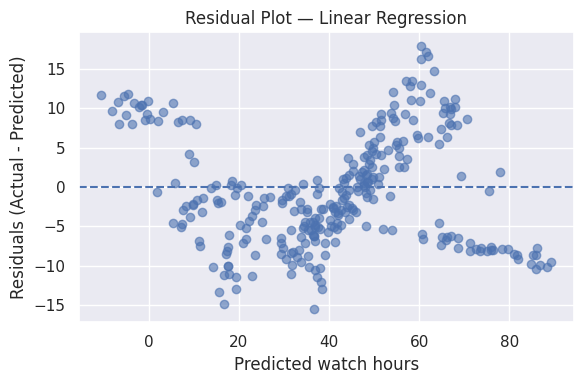

In [ ]:
# Residual plot
residuals = yr_test - yr_pred

plt.figure(figsize=(6,4))
plt.scatter(yr_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted watch hours")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot — Linear Regression")
plt.tight_layout()
plt.show()


In [ ]:
# Coefficient interpretation (top drivers)
ohe_reg = reg_pipe.named_steps["preprocess"].named_transformers_["cat"]
cat_names_reg = ohe_reg.get_feature_names_out(cat_reg)
feature_names_reg = np.concatenate([num_reg, cat_names_reg])

coef_reg = reg_pipe.named_steps["model"].coef_.ravel()
coef_reg_df = pd.DataFrame({"feature": feature_names_reg, "coef": coef_reg})
coef_reg_df["abs_coef"] = coef_reg_df["coef"].abs()

display(coef_reg_df.sort_values("abs_coef", ascending=False).head(15))


,feature,coef,abs_coef
7,watch_per_fee_ratio,21.275755,21.275755
4,monthly_fee,9.922765,9.922765
9,low_watch_time,-3.866538,3.866538
22,subscription_type_Standard,2.926310,2.926310
21,subscription_type_Premium,-1.826242,1.826242
20,subscription_type_Basic,-1.100068,1.100068
5,tenure_days,-0.561611,0.561611
14,country_Canada,-0.558712,0.558712
8,heavy_mobile_user,0.554940,0.554940
24,received_promotions_Yes,0.504165,0.504165
